<a href="https://colab.research.google.com/github/REICHIYAN/REI/blob/master/TradingStrategyDualMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


File not found...downloading the GOOG data
{'id': 1, 'price': 94.96405029296875, 'quantity': 1000, 'side': 'buy', 'status': 'accepted', 'action': 'New'}
{'id': 1, 'price': 94.96405029296875, 'quantity': 1000, 'side': 'buy', 'status': 'filled', 'action': 'New'}
{'id': 2, 'price': 95.34263610839844, 'quantity': 1000, 'side': 'sell', 'status': 'accepted', 'action': 'New'}
{'id': 2, 'price': 95.34263610839844, 'quantity': 1000, 'side': 'sell', 'status': 'filled', 'action': 'New'}
{'id': 3, 'price': 109.47964477539062, 'quantity': 1000, 'side': 'buy', 'status': 'accepted', 'action': 'New'}
{'id': 3, 'price': 109.47964477539062, 'quantity': 1000, 'side': 'buy', 'status': 'filled', 'action': 'New'}
{'id': 4, 'price': 171.60678100585938, 'quantity': 1000, 'side': 'sell', 'status': 'accepted', 'action': 'New'}
{'id': 4, 'price': 171.60678100585938, 'quantity': 1000, 'side': 'sell', 'status': 'filled', 'action': 'New'}
{'id': 5, 'price': 185.21575927734375, 'quantity': 1000, 'side': 'buy', 'stat

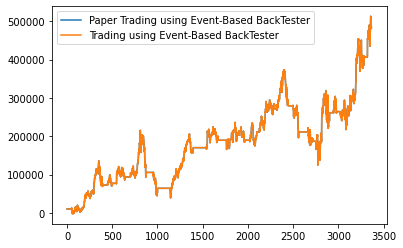

In [5]:
from chapter7.LiquidityProvider import LiquidityProvider
from chapter9.TradingStrategyDualMA import TradingStrategyDualMA
from chapter7.MarketSimulator import MarketSimulator
from chapter7.OrderManager import OrderManager
from chapter7.OrderBook import OrderBook
from collections import deque

import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt


def call_if_not_empty(deq, fun):
    while (len(deq) > 0):
        fun()


class EventBasedBackTester:
    def __init__(self):
        self.lp_2_gateway = deque()
        self.ob_2_ts = deque()
        self.ts_2_om = deque()
        self.ms_2_om = deque()
        self.om_2_ts = deque()
        self.gw_2_om = deque()
        self.om_2_gw = deque()


        self.lp = LiquidityProvider(self.lp_2_gateway)
        self.ob = OrderBook(self.lp_2_gateway, self.ob_2_ts)
        self.ts = TradingStrategyDualMA(self.ob_2_ts, self.ts_2_om,\
                                  self.om_2_ts)
        self.ms = MarketSimulator(self.om_2_gw, self.gw_2_om)
        self.om = OrderManager(self.ts_2_om, self.om_2_ts,\
                               self.om_2_gw, self.gw_2_om)


    def process_data_from_yahoo(self,price):

        order_bid = {
            'id': 1,
            'price': price,
            'quantity': 1000,
            'side': 'bid',
            'action': 'new'
        }
        order_ask = {
            'id': 1,
            'price': price,
            'quantity': 1000,
            'side': 'ask',
            'action': 'new'
        }
        self.lp_2_gateway.append(order_ask)
        self.lp_2_gateway.append(order_bid)
        self.process_events()
        order_ask['action']='delete'
        order_bid['action'] = 'delete'
        self.lp_2_gateway.append(order_ask)
        self.lp_2_gateway.append(order_bid)

    def process_events(self):
        while len(self.lp_2_gateway)>0:
            call_if_not_empty(self.lp_2_gateway,\
                                   self.ob.handle_order_from_gateway)
            call_if_not_empty(self.ob_2_ts, \
                                   self.ts.handle_input_from_bb)
            call_if_not_empty(self.ts_2_om, \
                                   self.om.handle_input_from_ts)
            call_if_not_empty(self.om_2_gw, \
                                   self.ms.handle_order_from_gw)
            call_if_not_empty(self.gw_2_om, \
                                   self.om.handle_input_from_market)
            call_if_not_empty(self.om_2_ts, \
                                   self.ts.handle_response_from_om)



eb=EventBasedBackTester()


def load_financial_data(start_date, end_date,output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        df = data.DataReader('GOOG', 'yahoo', start_date, end_date)
        df.to_pickle(output_file)
    return df

goog_data=load_financial_data(start_date='2001-01-01',
                    end_date = '2018-01-01',
                    output_file='goog_data.pkl')


for line in zip(goog_data.index,goog_data['Adj Close']):
    date=line[0]
    price=line[1]
    price_information={'date' : date,
                      'price' : float(price)}
    eb.process_data_from_yahoo(price_information['price'])
    eb.process_events()


plt.plot(eb.ts.list_paper_total,label="Paper Trading using Event-Based BackTester")
plt.plot(eb.ts.list_total,label="Trading using Event-Based BackTester")
plt.legend()
plt.show()